> Importing Basic Libraries:

# An Explainable AI Based Approach For Skin Cancer Classification

# Name: Sonali Agarkar






Install And Import Basic Libraries and Packages Needed

Install LIME and SHAP PAckages

In [ ]:
!pip install lime
!pip install shap

     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=efd17fe1c30449b3c87fa42c1cb36be54fa0bbd02b5a4a2d2fb642622c859ae9
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 564 kB 4.3 MB/s 


Import Basic Libraries for preprocessing, graphs, machine learning models and deep learning model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns;sns.set(style="white")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import random
import cv2
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from keras.models import Sequential

from keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from keras.utils import np_utils


import warnings
warnings.simplefilter("ignore")

> Loading Dataset:

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
  zip_ref.extractall("/content")


100% 5.19G/5.20G [01:38<00:00, 36.4MB/s]
100% 5.20G/5.20G [01:38<00:00, 56.4MB/s]


In [ ]:
df = pd.read_csv("/content/hmnist_28_28_RGB.csv")

print("Our orignal data-set have {} rows and {} columns. \n" .format(df.shape[0], df.shape[1]))

df.head()

Our orignal data-set have 10015 rows and 2353 columns. 



pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
meta = pd.read_csv("/content/HAM10000_metadata.csv")
print("Meta dataframe has {} image information.".format(meta.shape[0]))
meta.head()

Meta dataframe has 10015 image information.


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

EXploratory Data Analysis

In [ ]:
meta['age'].fillna((meta['age'].mean()), inplace=True) #replacing null values with mean values for age column

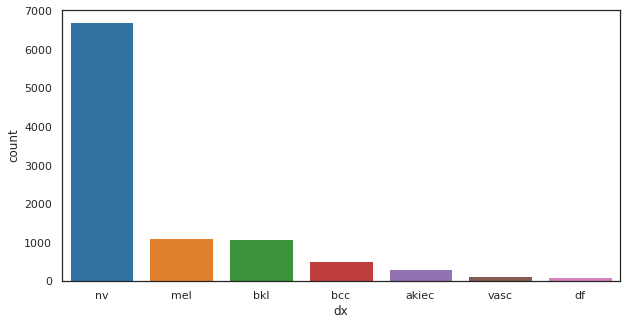

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
# # meta['dx'].value_counts().plot(kind='bar', ax=ax1)
sns.countplot(x = 'dx' , data = meta,order = meta['dx'].value_counts().index, palette="tab10")
plt.show()


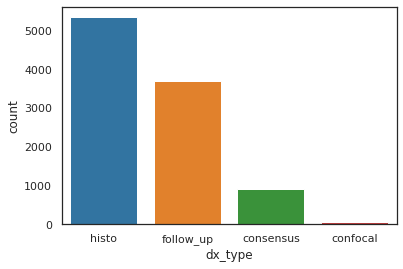

In [ ]:
sns.countplot(x = 'dx_type' , data = meta,order = meta['dx_type'].value_counts().index, palette="tab10")
plt.show()

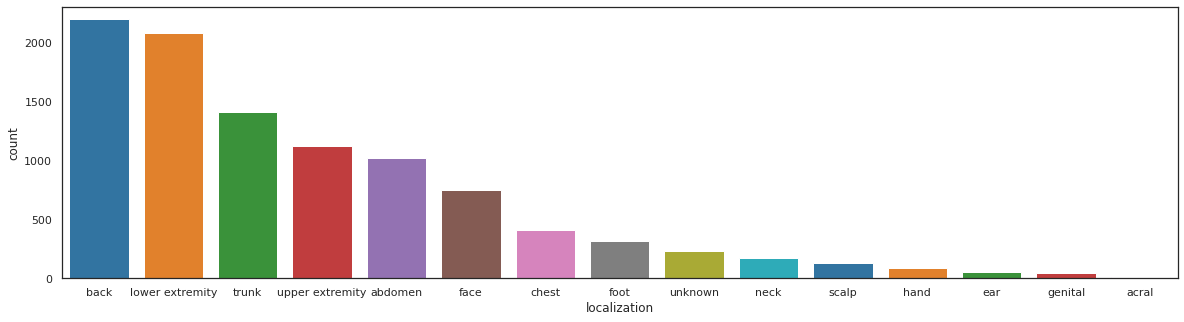

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (20, 5))
sns.countplot(x = 'localization' , data = meta, order = meta['localization'].value_counts().index, palette="tab10")


Text(0.5, 0, 'Age')

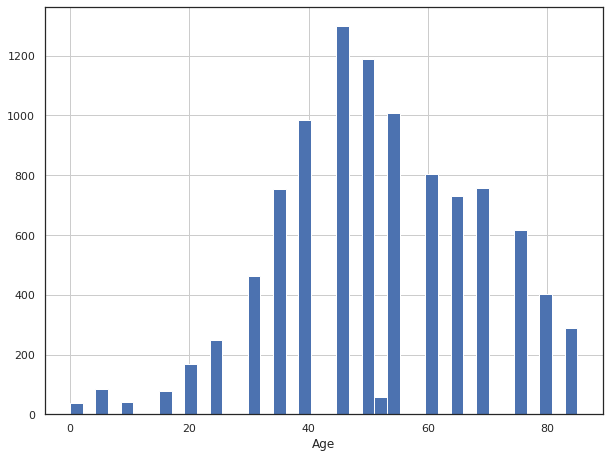

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 7.5))
meta['age'].hist(bins=40)
plt.xlabel('Age')


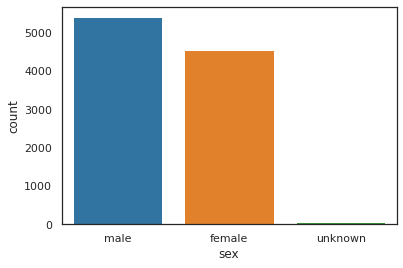

In [ ]:
sns.countplot(x = 'sex' , data = meta,order = meta['sex'].value_counts().index, palette="tab10")
plt.show()


In [ ]:
print("HAM10000_images_part_1 folder have {} images.".format(len(os.listdir("/content/HAM10000_images_part_1"))))
print("HAM10000_images_part_2 folder have {} images.".format(len(os.listdir("/content/HAM10000_images_part_2"))))

HAM10000_images_part_1 folder have 5000 images.
HAM10000_images_part_2 folder have 5015 images.


In [ ]:
nv_ls=[]
mel_ls=[]
bkl_ls=[]
bcc_ls=[]
akiec_ls=[]
vasc_ls=[]
df_ls=[] 

for i in os.listdir("/content/HAM10000_images_part_1"):
  try:
    image = cv2.imread("/content/HAM10000_images_part_1/"+i)
    image_array = Image.fromarray(image , 'RGB')
    resize_img = image_array.resize((50 , 50))
    dx = meta.loc[meta["image_id"]==i.split(".")[0], "dx"].values[0]

    if dx == "nv":
      nv_ls.append(resize_img)
    elif dx == "mel":
      mel_ls.append(resize_img)
    elif dx == "bkl":
      bkl_ls.append(resize_img)
    elif dx == "bcc":
      bcc_ls.append(resize_img)
    elif dx == "akiec":
      akiec_ls.append(resize_img)
    elif dx == "vasc":
      vasc_ls.append(resize_img)
    elif dx == "df":
      df_ls.append(resize_img)
        
  except AttributeError:
    pass


  
for u in os.listdir("/content/HAM10000_images_part_2"):
  try:
    image = cv2.imread("/content/HAM10000_images_part_2/"+u)
    image_array = Image.fromarray(image , 'RGB')
    resize_img = image_array.resize((50 , 50))
    dx = meta.loc[meta["image_id"]==u.split(".")[0], "dx"].values[0]
    if dx == "nv":
      nv_ls.append(resize_img)
    elif dx == "mel":
      mel_ls.append(resize_img)
    elif dx == "bkl":
      bkl_ls.append(resize_img)
    elif dx == "bcc":
      bcc_ls.append(resize_img)
    elif dx == "akiec":
      akiec_ls.append(resize_img)
    elif dx == "vasc":
      vasc_ls.append(resize_img)
    elif dx == "df":
      df_ls.append(resize_img)
  except AttributeError:
    pass



In [ ]:
meta["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

> Before Augmentaion:

In [ ]:


bcc_up = random.choices(population=bcc_ls, k=1500)
akiec_up = random.choices(population=akiec_ls, k=1000)
vasc_up = random.choices(population=vasc_ls, k=1000)
df_up = random.choices(population=df_ls, k=1000)


nv_label = ["nv" for i in range(len(nv_ls))]
mel_label = ["mel" for i in range(len(mel_ls))]
bkl_label = ["bkl" for i in range(len(bkl_ls))]
bcc_label = ["bcc" for i in range(len(bcc_up))]
akiec_label = ["akiec" for i in range(len(akiec_up))]
vasc_label = ["vasc" for i in range(len(vasc_up))]
df_label = ["df" for i in range(len(df_up))]


or_data= nv_ls + mel_ls + bkl_ls+ bcc_up+ akiec_up+ vasc_up+ df_up
org_data = [np.array(i) for i in or_data]
or_labels= nv_label + mel_label + bkl_label + bcc_label + akiec_label + vasc_label+ df_label

org_data = np.array(org_data)
or_labels = np.array(or_labels)
# or_labels = [label[0] for label in or_labels.tolist()]

print('Before Augmentaion')
print('Data : {} | labels : {}'.format(org_data.shape , len(or_labels)))

Before Augmentaion
Data : (13417, 50, 50, 3) | labels : 13417


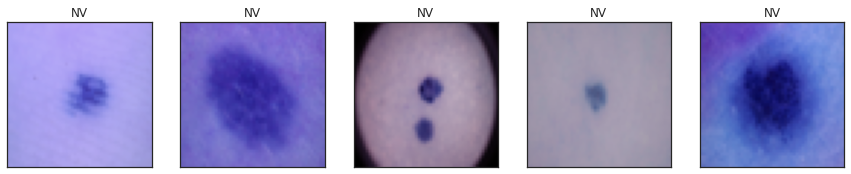

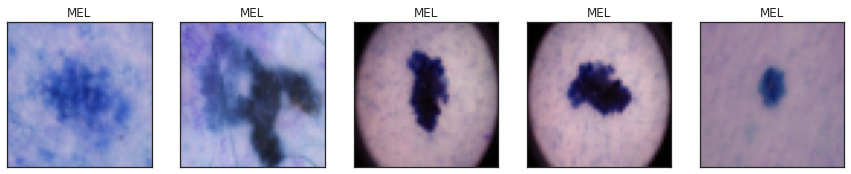

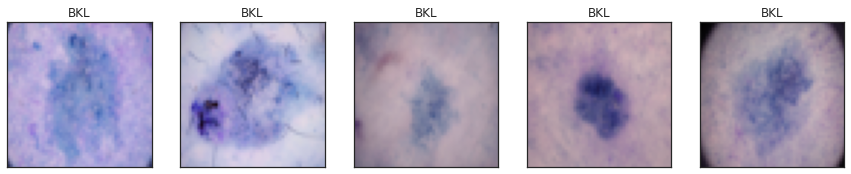

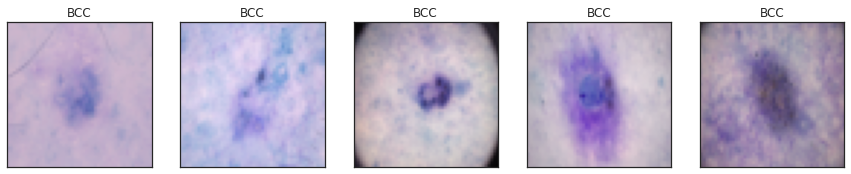

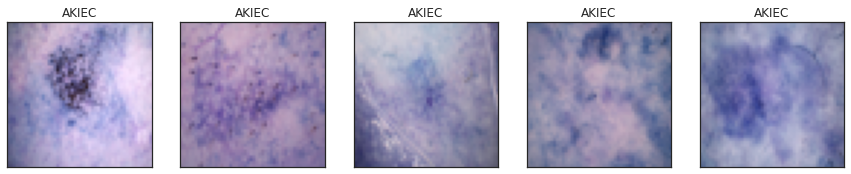

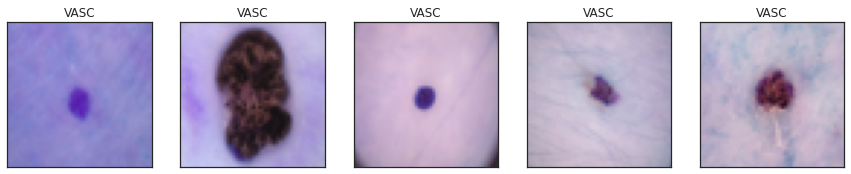

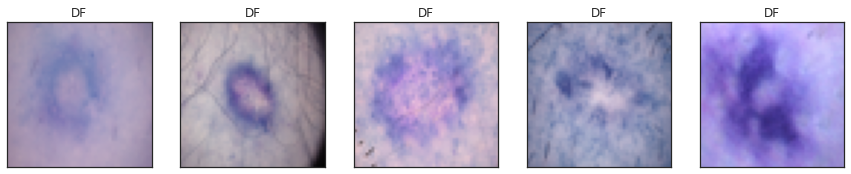

In [ ]:
uni_labels=[]
for label in range(len(or_labels)):
  if or_labels[label] not in uni_labels:
    uni_labels.append(or_labels[label])
# print(uni_labels)


for uni in uni_labels:
  ls=[]
  for label in range(len(or_labels)):
    if or_labels[label] == uni:
      ls.append(label)
  ls =  random.choices(population=ls, k=5)

  plt.figure(figsize=(15,5))
  for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(org_data[ls[i-1]])
    plt.title(uni.upper())
    plt.xticks([])
    plt.yticks([])



> After Augmentaion:

In [ ]:
data = []
labels = []

for index in range(len(or_data)):
  resize_img = or_data[index]
  dx = or_labels[index]
  rotated90 = resize_img.rotate(90)
  blur = cv2.blur(np.array(resize_img),(10,10))
  data.append(np.array(resize_img))
  data.append(np.array(rotated90))
  data.append(np.array(blur))
  labels.append(dx)
  labels.append(dx)
  labels.append(dx)

data = np.array(data)
labels = np.array(labels)
# labels = [label[0] for label in labels.tolist()]
print('After Augmentaion')
print('Data : {} | labels : {}'.format(data.shape , len(labels)))

After Augmentaion
Data : (40251, 50, 50, 3) | labels : 40251


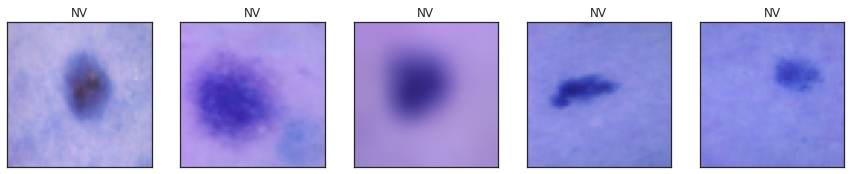

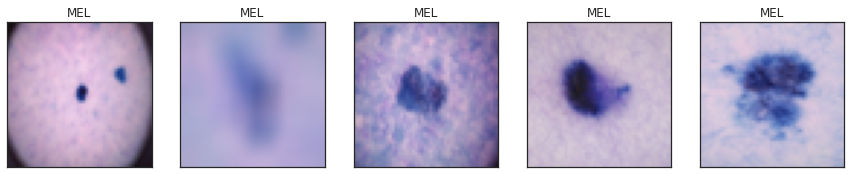

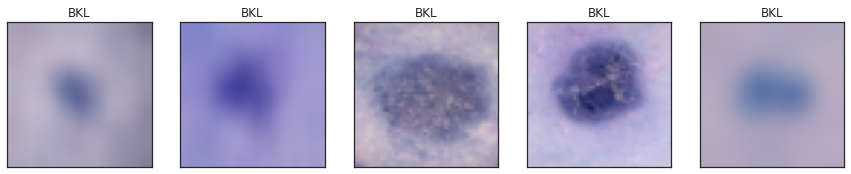

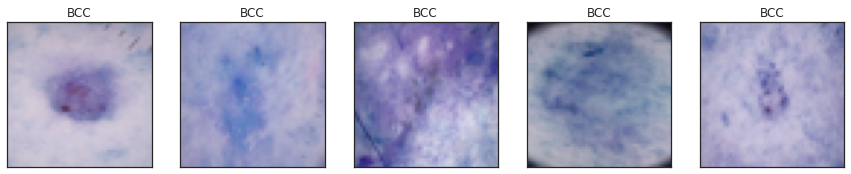

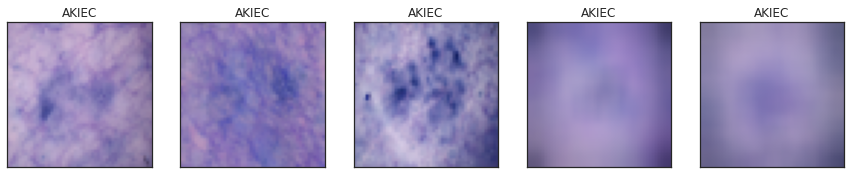

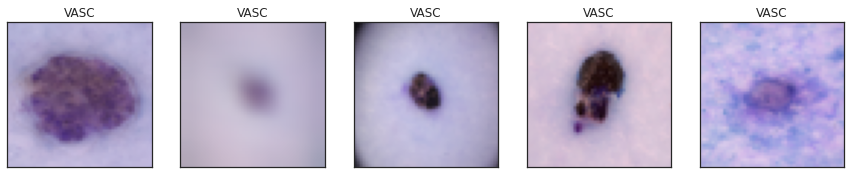

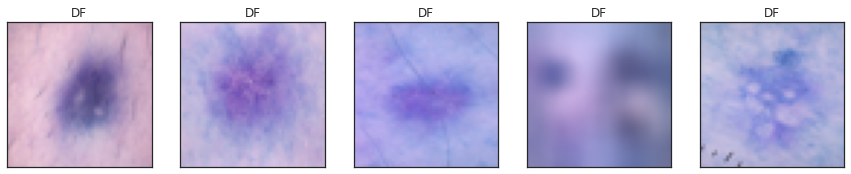

In [ ]:
uni_labels=[]
for label in range(len(labels)):
  if labels[label] not in uni_labels:
    uni_labels.append(labels[label])
# print(uni_labels)


for uni in uni_labels:
  ls=[]
  for label in range(len(labels)):
    if labels[label] == uni:
      ls.append(label)
  ls =  random.choices(population=ls, k=5)

  plt.figure(figsize=(15,5))
  for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(data[ls[i-1]])
    plt.title(uni.upper())
    plt.xticks([])
    plt.yticks([])



> One Hot Encoding:

In [ ]:
labelEncoder = preprocessing.LabelEncoder()

mapping_dict={}
labels = labelEncoder.fit_transform(labels)
le_name_mapping = dict(zip(labelEncoder.classes_, labelEncoder.transform(labelEncoder.classes_)))
le_name_mapping

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

> Splitting Data-set into Train and Test

In [ ]:
n = np.arange(data.shape[0])
np.random.shuffle(n)
data = data[n]
labels = labels[n] 
data = data.astype(np.float32)
labels = labels.astype(np.int32)



In [ ]:
train_x , test_x , train_y , test_y = train_test_split(data , labels , test_size = 0.3, stratify = labels)


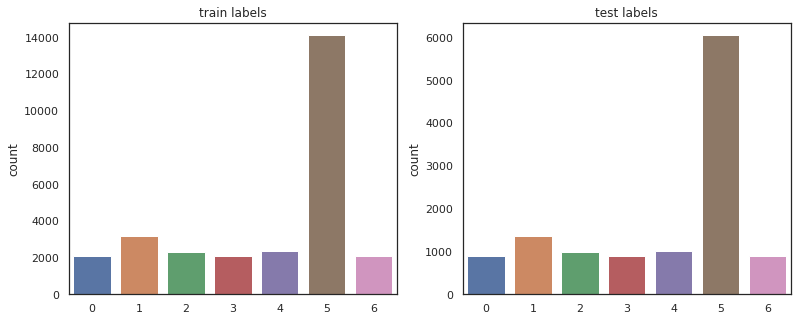

Y train shape (28175, 7)


In [ ]:
plt.figure(1 , figsize = (20 ,5))
n = 0 
for z , j in zip([train_y , test_y] , ['train labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()


train_y=np_utils.to_categorical(train_y,num_classes=7)
test_y=np_utils.to_categorical(test_y,num_classes=7)

print("Y train shape",train_y.shape)

In [ ]:
print('train data shape {} , test data shape {}'.format(train_x.shape, test_x.shape))

train data shape (28175, 50, 50, 3) , test data shape (12076, 50, 50, 3)


> CNN:

In [ ]:
keras.backend.clear_session()

cnn = Sequential()
cnn.add(Convolution2D(32,(3,3),activation='relu',input_shape = (50, 50, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))
cnn.add(Dropout(0.2))
cnn.add(Convolution2D(32,(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))
cnn.add(Dropout(0.2))
cnn.add(Convolution2D(64,(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(64,activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(7,activation='softmax'))
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
%%time
early_stopping_monitor = EarlyStopping(patience = 3) 
nn = cnn.fit(train_x, train_y, epochs = 20, validation_split = 0.2, callbacks = [early_stopping_monitor])

Epoch 1/20
705/705 [==============================] - 4s 5ms/step - loss: 1.1726 - accuracy: 0.5890 - val_loss: 1.2830 - val_accuracy: 0.5240
Epoch 2/20
705/705 [==============================] - 4s 5ms/step - loss: 0.9664 - accuracy: 0.6496 - val_loss: 1.3227 - val_accuracy: 0.5581
Epoch 3/20
705/705 [==============================] - 4s 5ms/step - loss: 0.8991 - accuracy: 0.6709 - val_loss: 1.0567 - val_accuracy: 0.6217
Epoch 4/20
705/705 [==============================] - 4s 5ms/step - loss: 0.8325 - accuracy: 0.6916 - val_loss: 1.8232 - val_accuracy: 0.4708
Epoch 5/20
705/705 [==============================] - 4s 5ms/step - loss: 0.7843 - accuracy: 0.7106 - val_loss: 0.8450 - val_accuracy: 0.6894
Epoch 6/20
705/705 [==============================] - 4s 5ms/step - loss: 0.7433 - accuracy: 0.7234 - val_loss: 0.6889 - val_accuracy: 0.7526
Epoch 7/20
705/705 [==============================] - 4s 5ms/step - loss: 0.7018 - accuracy: 0.7434 - val_loss: 0.7129 - val_accuracy: 0.7432
Epoch 

In [ ]:
values  = nn.history
validation_loss = values['val_loss']
validation_acc = values['val_accuracy']
training_acc = values['accuracy']
training_loss = values['loss']
epochs = range(1, len(training_acc) + 1)

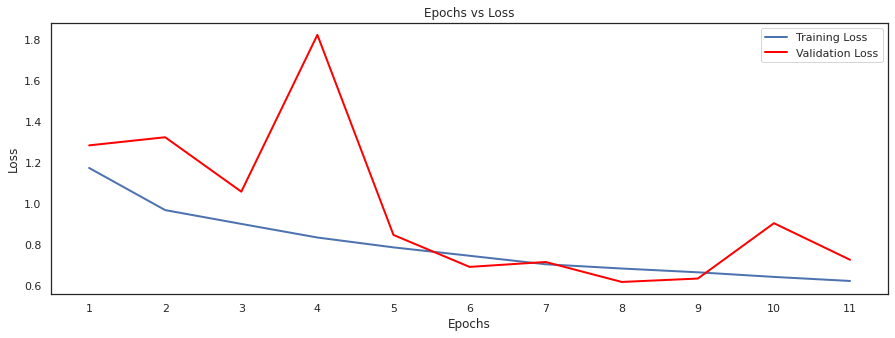

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.plot(epochs,training_loss,label = 'Training Loss',linewidth = 2)
plt.plot(epochs,validation_loss,label = 'Validation Loss',linewidth = 2, color = "red")
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.show()

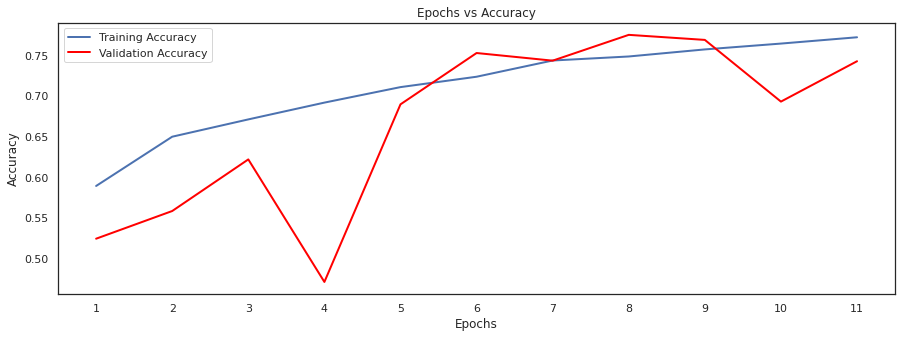

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.plot(epochs,training_acc,label = 'Training Accuracy',linewidth =2)
plt.plot(epochs,validation_acc,label = 'Validation Accuracy', linewidth =2, color= "red")
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions= cnn.predict(test_x).round(0)
loss1, test_acc = cnn.evaluate(test_x, test_y)
test_acc = test_acc*100

loss2, train_acc = cnn.evaluate(train_x, train_y)
train_acc = train_acc*100

print('Test Loss score:', loss1)
print('Test accuracy:', test_acc)

print('Train Loss score:', loss2)
print('Train accuracy:', train_acc)

target= ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

print("Classification Report: \n",classification_report(test_y, predictions, target_names=target)) 
print()
print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predictions, axis=1))
cm =pd.DataFrame(cm, index=target, columns=target)
cm

881/881 [==============================] - 3s 3ms/step - loss: 0.6416 - accuracy: 0.7661
Test Loss score: 0.706132173538208
Test accuracy: 74.44518208503723
Train Loss score: 0.6416332721710205
Train accuracy: 76.61046981811523
Classification Report: 
               precision    recall  f1-score   support

       akiec       0.63      0.69      0.66       900
         bcc       0.64      0.69      0.67      1350
         bkl       0.47      0.39      0.43       989
          df       0.96      0.61      0.74       900
         mel       0.65      0.14      0.22      1002
          nv       0.88      0.82      0.85      6035
        vasc       0.98      0.86      0.92       900

   micro avg       0.80      0.69      0.74     12076
   macro avg       0.74      0.60      0.64     12076
weighted avg       0.79      0.69      0.72     12076
 samples avg       0.69      0.69      0.69     12076


Confusion Matrix:


akiec  bcc  bkl   df  mel    nv  vasc
akiec    743  105   19    0    0    33     0
bcc      335  935   37    6    0    34     3
bkl      303   72  385    5   16   203     5
df       229   90   10  545    0    26     0
mel      342   30  106    3  136   379     6
nv       576  198  255    7   58  4939     2
vasc      61   28    2    4    0    30   775

AUC ROC curves For CNN model

ROC AUC score: 0.7817417727207214


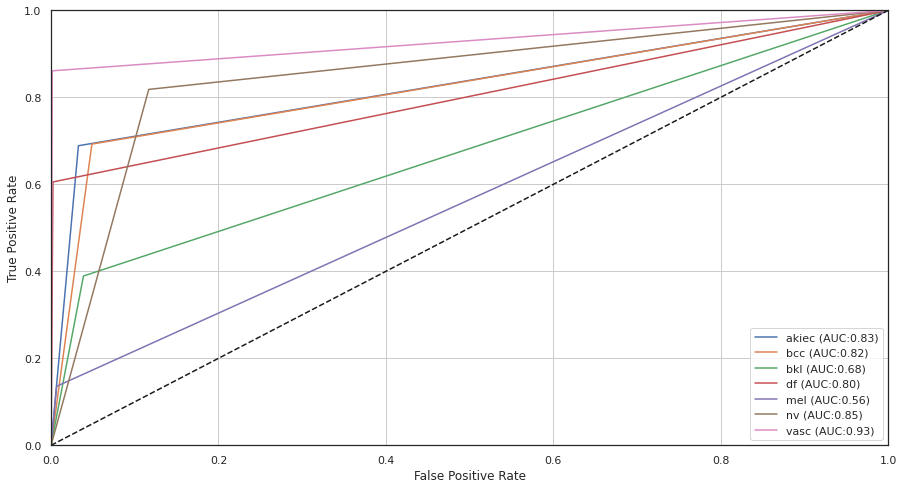

In [ ]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
ypred = cnn.predict(test_x)
ypred = ypred.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots( )
fig.set_size_inches(15, 8)
plt.xlim((0,1))
plt.ylim((0,1))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(test_y)
    y_test = lb.transform(test_y)
    y_pred = lb.transform(predictions)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
   
    return roc_auc_score(test_y, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_y, predictions))
plt.grid()
plt.plot([0, 1], [0, 1], 'k--')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
# visualizer.show() 

LIME Explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

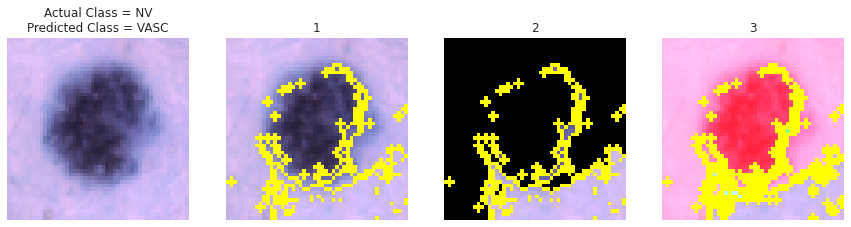

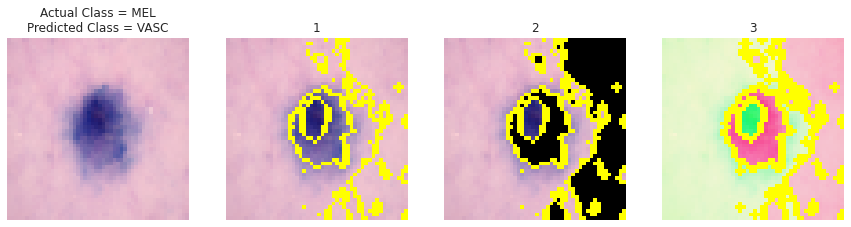

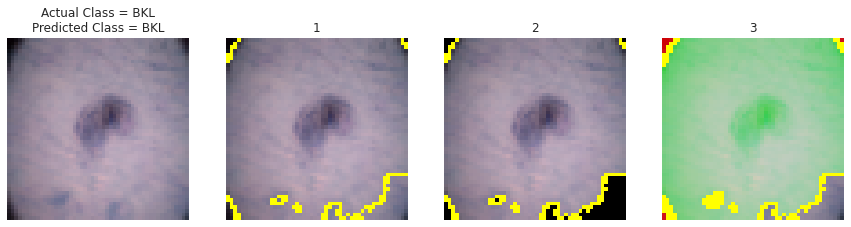

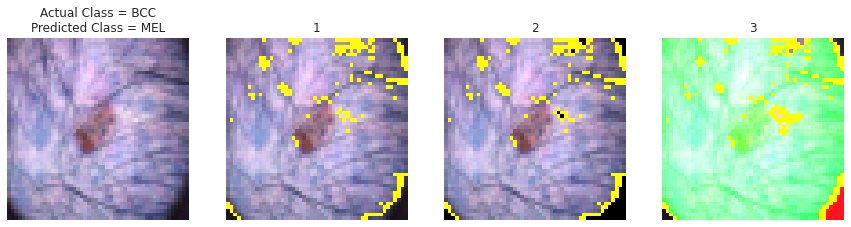

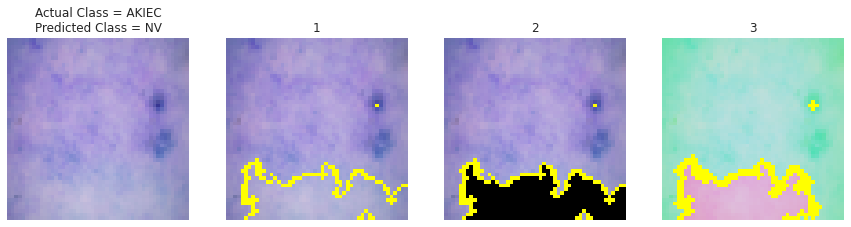

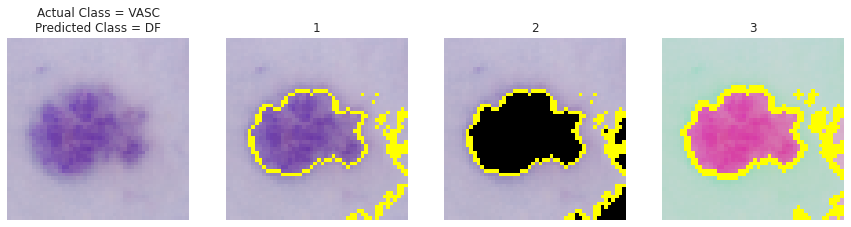

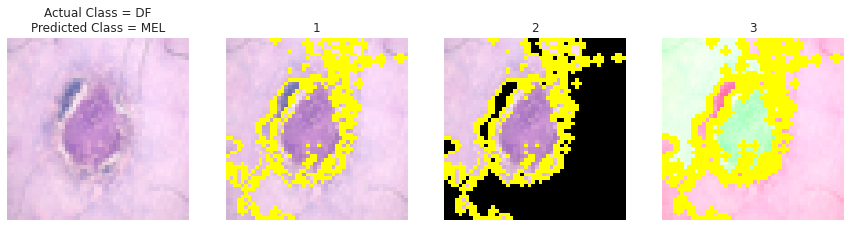

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries


explainer = lime_image.LimeImageExplainer(verbose = False)


n=0

title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]

rando_num = random.randint(1,100)
pre =  np.array([np.array(i[rando_num])  for i in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]])
pre = cnn.predict(pre).round(0).argmax(axis=1).tolist()

for ls in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]:
  explanation = explainer.explain_instance(
      np.array(ls[rando_num]).astype('double'), 
      classifier_fn = cnn.predict, 
      top_labels=100, 
      hide_color=0, 
      num_samples=1000,
  )

  temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0], 
      positive_only=True, 
      num_features=5, 
      hide_rest=False
  )
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,15))
  ax1.imshow(np.array(ls[rando_num]))
  ax2.imshow(mark_boundaries(temp / 255, mask))
  temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  ax3.imshow(mark_boundaries(temp1 / 255, mask1))
  temp3, mask3= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  ax4.imshow(mark_boundaries(temp3 / 255, mask3))
  ax1.set_title("Actual Class = {}\nPredicted Class = {}".format(title[n], title[pre[n]]))
  ax1.axis('off')
  ax2.set_title("1")
  ax2.axis('off')
  ax3.set_title("2")
  ax3.axis('off')
  ax4.set_title("3")
  ax4.axis('off')
  n+=1

SHAP Explanaltions

Actual Class = VASC Predicted Class = AKIEC


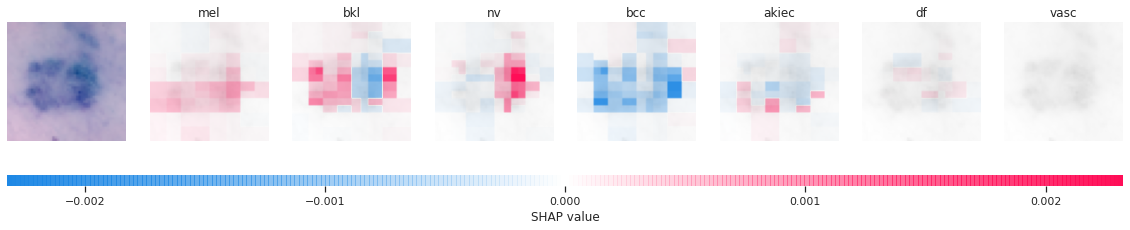

Actual Class = VASC Predicted Class = VASC


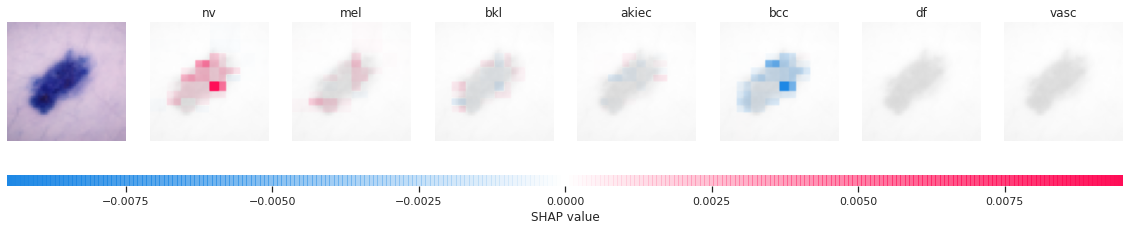

Actual Class = BKL Predicted Class = VASC


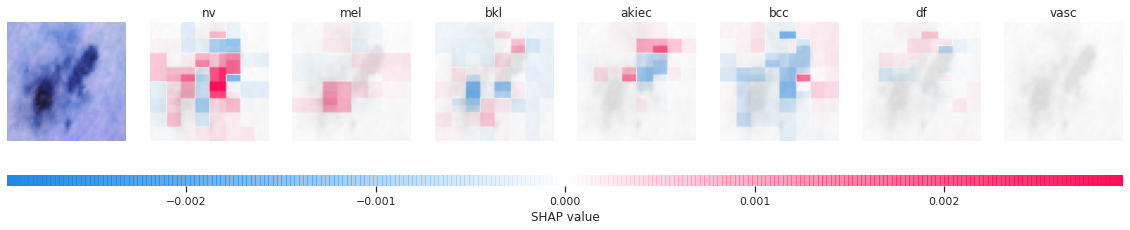

Actual Class = BKL Predicted Class = DF


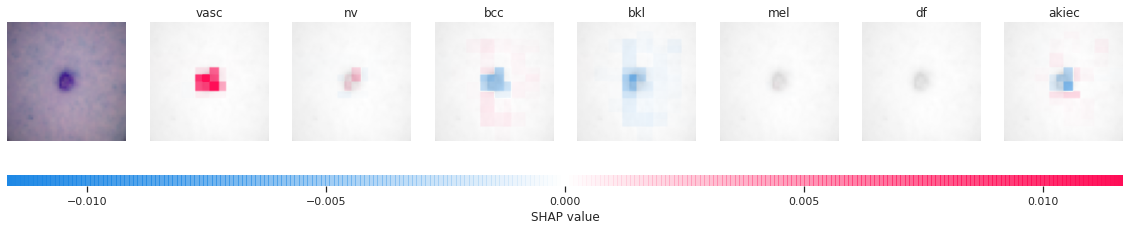

Actual Class = VASC Predicted Class = VASC


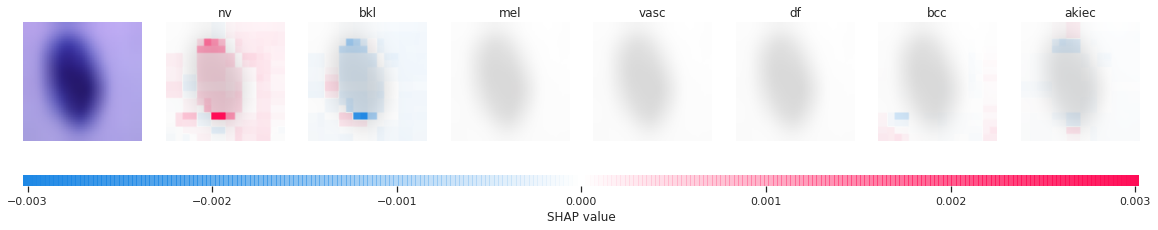

Actual Class = VASC Predicted Class = NV


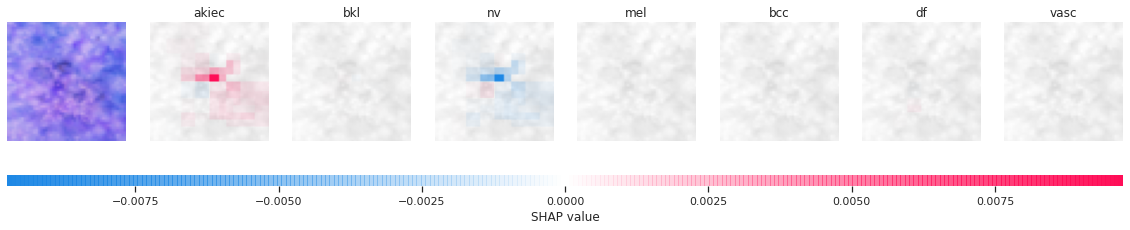

Actual Class = BCC Predicted Class = MEL


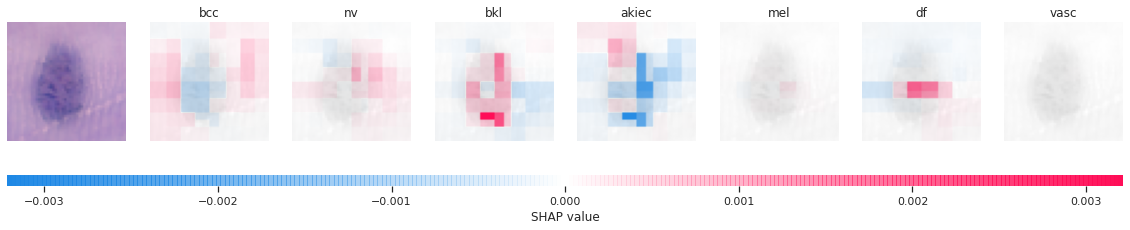

In [ ]:
import shap

# load pre-trained model and choose two images to explain
model = cnn

title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]

for ls in range(len(title)):

  # define a masker that is used to mask out partitions of the input image, this one uses a blurred background
  masker = shap.maskers.Image("inpaint_telea", (50,50,3))

  # By default the Partition explainer is used for all  partition explainer
  explainer = shap.Explainer(model, masker, output_names=target)
  rando_num = random.randint(1,len(data))
  model_pred = model.predict(data[rando_num-1:rando_num]).argmax(axis=1)[0]
  # print(model_pred)
  # here we use 1000 evaluations of the underlying model to estimate the SHAP values
  print("Actual Class = {} Predicted Class = {}".format(title[labels[rando_num]], title[model_pred]))
  shap_values = explainer(data[rando_num-1:rando_num], max_evals=1000, batch_size=32, outputs=shap.Explanation.argsort.flip[:7])
  shap.image_plot(shap_values)


> ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights="imagenet",include_top = False,input_shape=(50,50,3))

for layer in resnet.layers:
  layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet50 = Sequential()
resnet50.add(resnet)
resnet50.add(Flatten())
resnet50.add(Dense(7,activation="softmax"))
resnet50.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
%%time

checkpoint = ModelCheckpoint("resnet50.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

history = resnet50.fit(train_x,train_y,batch_size=32,epochs=20, validation_data=(test_x,test_y), verbose=1, callbacks=[checkpoint,earlystop])

Epoch 1/20
881/881 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.6795
Epoch 1: val_accuracy improved from -inf to 0.72739, saving model to resnet50.h5
881/881 [==============================] - 23s 23ms/step - loss: 1.2036 - accuracy: 0.6795 - val_loss: 1.0314 - val_accuracy: 0.7274
Epoch 2/20
879/881 [============================>.] - ETA: 0s - loss: 0.7986 - accuracy: 0.7762
Epoch 2: val_accuracy improved from 0.72739 to 0.76590, saving model to resnet50.h5
881/881 [==============================] - 19s 22ms/step - loss: 0.7988 - accuracy: 0.7761 - val_loss: 0.8727 - val_accuracy: 0.7659
Epoch 3/20
881/881 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.8109
Epoch 3: val_accuracy improved from 0.76590 to 0.76996, saving model to resnet50.h5
881/881 [==============================] - 19s 21ms/step - loss: 0.6685 - accuracy: 0.8109 - val_loss: 0.8815 - val_accuracy: 0.7700
Epoch 4/20
880/881 [============================>.] - ETA: 0s - 

In [ ]:
values  = history.history
validation_loss = values['val_loss']
validation_acc = values['val_accuracy']
training_acc = values['accuracy']
training_loss = values['loss']
epochs = range(1, len(training_acc) + 1)

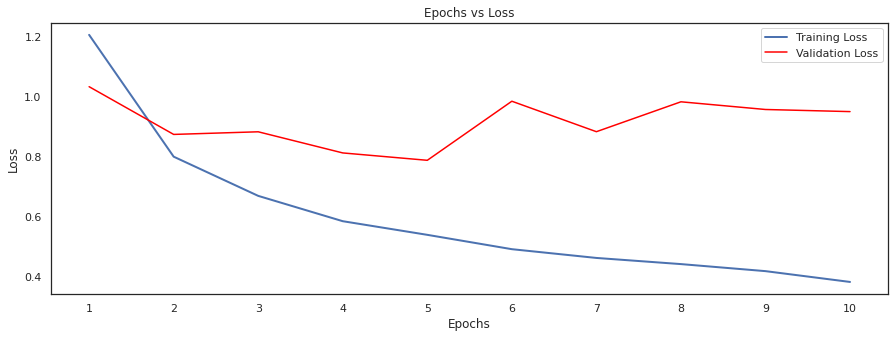

In [ ]:
# visualization of overall model performance 

plt.figure(1 , figsize = (15 ,5))
plt.plot(epochs,training_loss,label = 'Training Loss', linewidth= 2)
plt.plot(epochs,validation_loss,label = 'Validation Loss', color="red")
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.show()


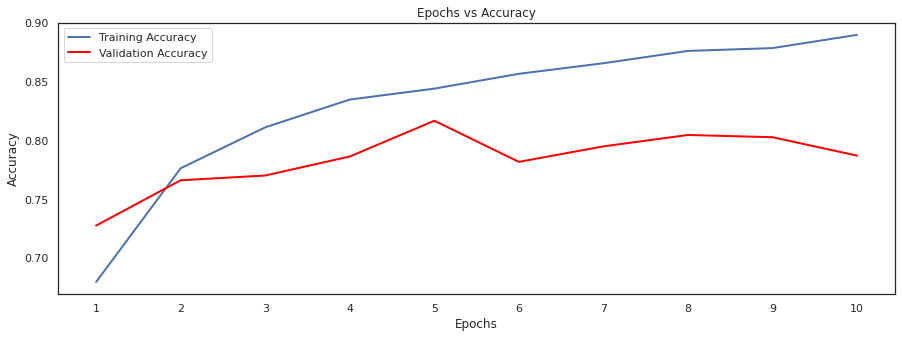

In [ ]:
# visualization of overall model performance 

plt.figure(1 , figsize = (15 ,5))
plt.plot(epochs,training_acc,label = 'Training Accuracy',linewidth = 2)
plt.plot(epochs,validation_acc,label = 'Validation Accuracy', color="red", linewidth = 2)
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Performance Score and Confusion matrix

In [ ]:
predictions= resnet50.predict(test_x).round(0)
loss1, test_acc = resnet50.evaluate(test_x, test_y)
test_acc = test_acc*100

loss2, train_acc = resnet50.evaluate(train_x, train_y)
train_acc = train_acc*100

print('Test Loss score:', loss1)
print('Test accuracy:', test_acc)

print('Train Loss score:', loss2)
print('Train accuracy:', train_acc)

print("Classification Report: \n",classification_report(test_y, predictions, target_names=target)) 
print()
print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predictions, axis=1))
cm =pd.DataFrame(cm, index=target, columns=target)
cm

881/881 [==============================] - 13s 15ms/step - loss: 0.3054 - accuracy: 0.8889
Test Loss score: 0.9485683441162109
Test accuracy: 78.68499755859375
Train Loss score: 0.30541926622390747
Train accuracy: 88.89440894126892
Classification Report: 
               precision    recall  f1-score   support

       akiec       0.91      0.73      0.81       900
         bcc       0.90      0.73      0.81      1350
         bkl       0.36      0.56      0.44       989
          df       0.87      1.00      0.93       900
         mel       0.46      0.47      0.47      1002
          nv       0.91      0.82      0.86      6035
        vasc       0.96      0.98      0.97       900

   micro avg       0.80      0.78      0.79     12076
   macro avg       0.77      0.75      0.75     12076
weighted avg       0.83      0.78      0.80     12076
 samples avg       0.78      0.78      0.78     12076


Confusion Matrix:


akiec  bcc  bkl   df  mel    nv  vasc
akiec    724   10   99   23   31    13     0
bcc       85  988  174   42   26    31     4
bkl       55   31  552   14  152   178     7
df         0    0    0  900    0     0     0
mel       52   23  176   14  472   263     2
nv       106   51  532   40  343  4938    25
vasc       8    0    7    0    2     4   879

AUC ROC curves for Resnet50

ROC AUC score: 0.8595060836638301


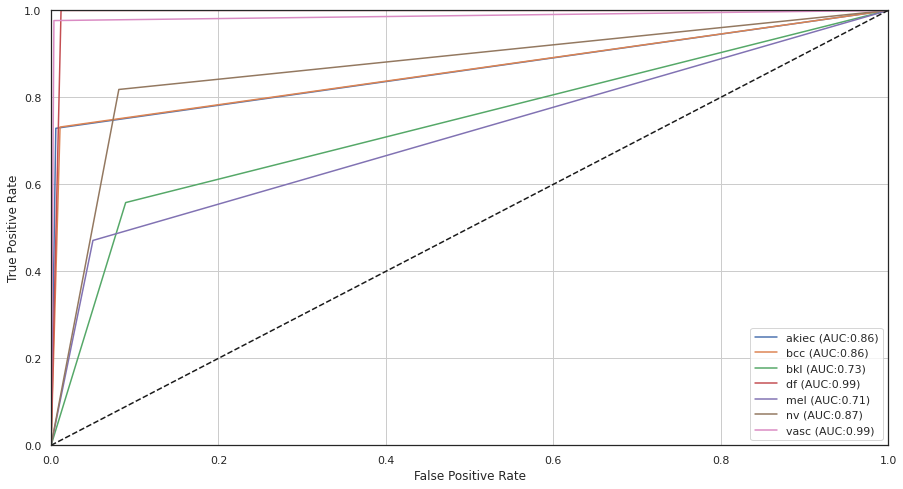

In [ ]:
ypred = resnet50.predict(test_x)
ypred = ypred.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots( )
fig.set_size_inches(15, 8)
plt.xlim((0,1))
plt.ylim((0,1))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(test_y)
    y_test = lb.transform(test_y)
    y_pred = lb.transform(predictions)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
   
    return roc_auc_score(test_y, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_y, predictions))
plt.grid()
plt.plot([0, 1], [0, 1], 'k--')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
# visualizer.show() 

LIME Explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

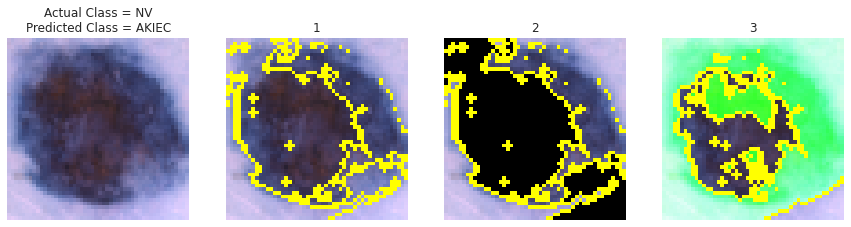

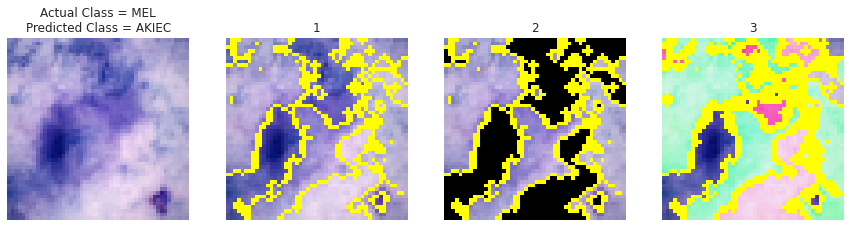

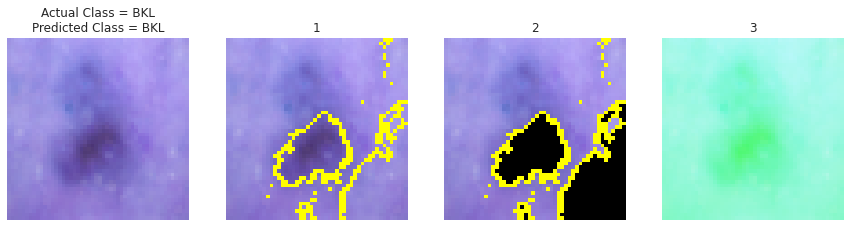

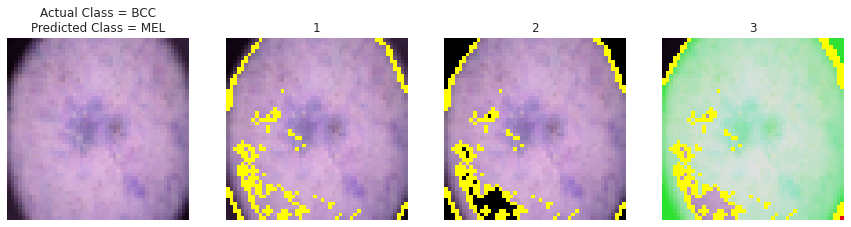

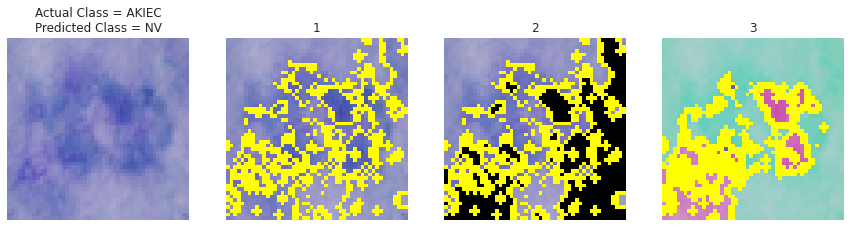

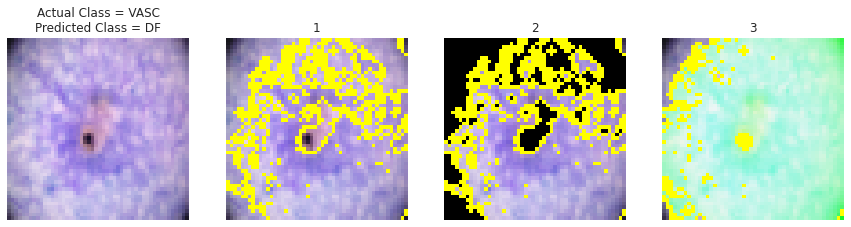

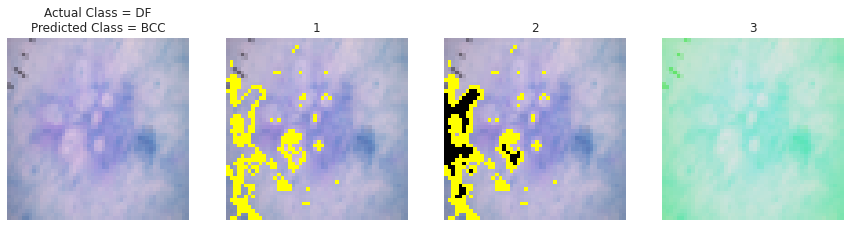

In [ ]:
explainer = lime_image.LimeImageExplainer(verbose = False)


n=0

title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]

rando_num = random.randint(1,100)

pre =  np.array([np.array(i[rando_num])  for i in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]])
pre = resnet50.predict(pre).round(0).argmax(axis=1).tolist()

for ls in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]:
  explanation = explainer.explain_instance(
      np.array(ls[rando_num]).astype('double'), 
      classifier_fn = resnet50.predict, 
      top_labels=100, 
      hide_color=0, 
      num_samples=1000,
  )

  temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0], 
      positive_only=True, 
      num_features=5, 
      hide_rest=False
  )
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,15))
  ax1.imshow(np.array(ls[rando_num]))
  ax2.imshow(mark_boundaries(temp / 255, mask))
  temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  ax3.imshow(mark_boundaries(temp1 / 255, mask1))
  temp3, mask3= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  ax4.imshow(mark_boundaries(temp3 / 255, mask3))
  ax1.set_title("Actual Class = {}\nPredicted Class = {}".format(title[n], title[pre[n]]))
  ax1.axis('off')
  ax2.set_title("1")
  ax2.axis('off')
  ax3.set_title("2")
  ax3.axis('off')
  ax4.set_title("3")
  ax4.axis('off')
  n+=1

SHAP Explanations

Actual Class = AKIEC Predicted Class = VASC


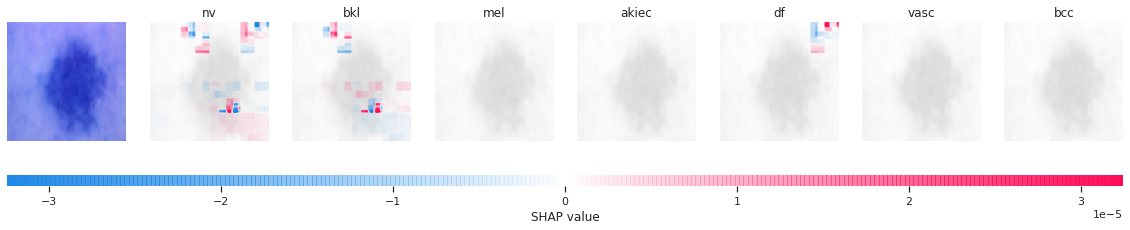

Actual Class = VASC Predicted Class = MEL


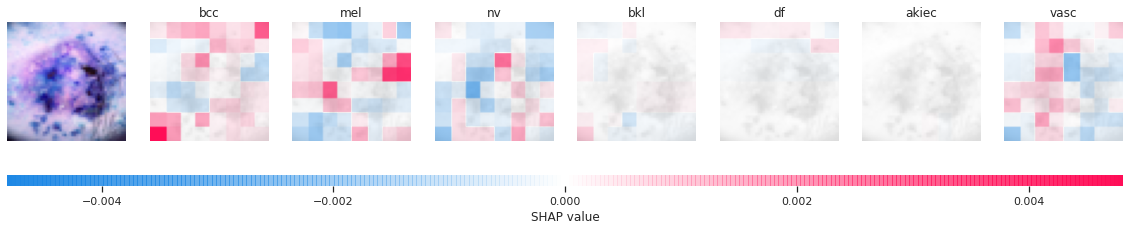

Actual Class = BKL Predicted Class = BKL


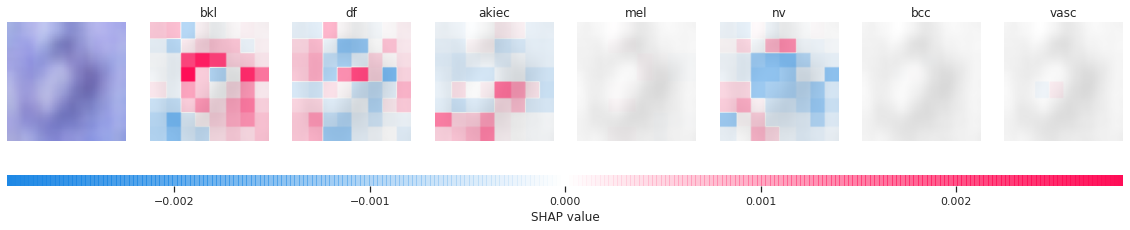

Actual Class = VASC Predicted Class = VASC


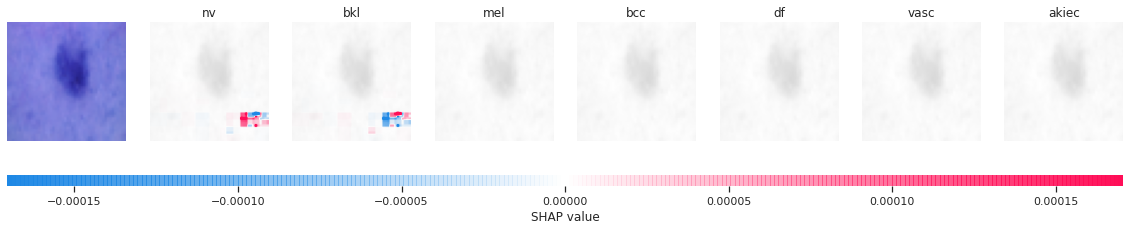

Actual Class = VASC Predicted Class = VASC


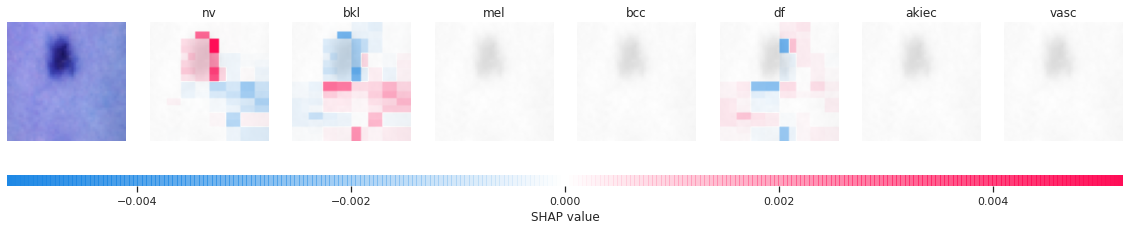

Actual Class = BKL Predicted Class = VASC


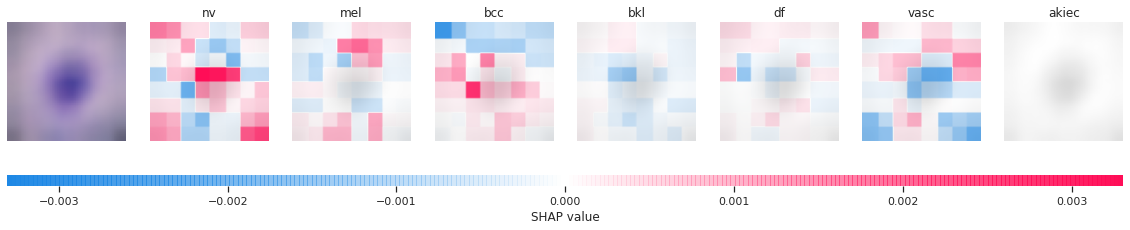

Actual Class = VASC Predicted Class = DF


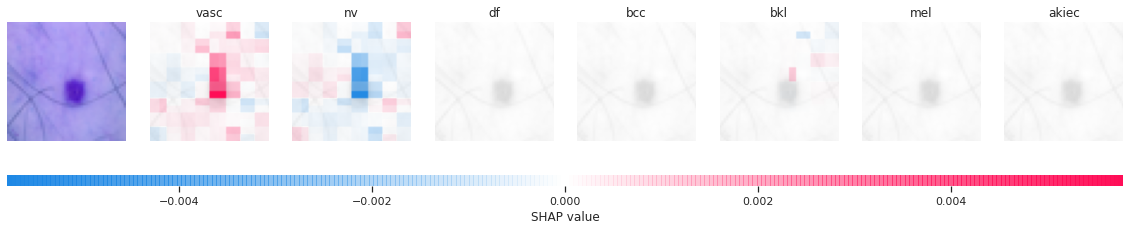

In [ ]:
model = resnet50

title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]

for ls in range(len(title)):

  # define a masker that is used to mask out partitions of the input image, this one uses a blurred background
  masker = shap.maskers.Image("inpaint_telea", (50,50,3))

  # By default the Partition explainer is used for all  partition explainer
  explainer = shap.Explainer(model, masker, output_names=target)
  rando_num = random.randint(1,len(data))
  model_pred = model.predict(data[rando_num-1:rando_num]).argmax(axis=1)[0]
  # print(model_pred)
  # here we use 500 evaluations of the underlying model to estimate the SHAP values
  print("Actual Class = {} Predicted Class = {}".format(title[labels[rando_num]], title[model_pred]))
  shap_values = explainer(data[rando_num-1:rando_num], max_evals=1000, batch_size=32, outputs=shap.Explanation.argsort.flip[:7])
  shap.image_plot(shap_values)


In [ ]:
flat_image = [] 

for img in data:
  flat_image.append(img.flatten())

flat_data=np.array(flat_image)
df=pd.DataFrame(flat_data)
df["labels"]=labels

In [ ]:
X= df.drop("labels", axis=1)

y = df["labels"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

In [ ]:

target= ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

> Random Forest:

In [ ]:
%%time


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train,y_train)

predictions= rf.predict(X_test)

train_acc = rf.score(X_train, y_train)*100
test_acc = rf.score(X_test, y_test)*100

CPU times: user 3min 4s, sys: 0 ns, total: 3min 4s
Wall time: 3min 3s


In [ ]:
print("Accuracy on training set: {:.3f}%. \n".format(train_acc))
print("Accuracy on test set: {:.3f}%. \n".format(test_acc))

print("Classification Report: \n",classification_report(y_test, predictions, target_names=target)) 
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predictions)
cm =pd.DataFrame(cm, index=target, columns=target)
cm

Accuracy on training set: 100.000%. 

Accuracy on test set: 85.185%. 

Classification Report: 
               precision    recall  f1-score   support

       akiec       0.92      0.95      0.94       900
         bcc       0.89      0.94      0.92      1350
         bkl       0.65      0.36      0.46       989
          df       1.00      1.00      1.00       900
         mel       0.68      0.19      0.30      1002
          nv       0.82      0.97      0.89      6035
        vasc       1.00      0.99      0.99       900

    accuracy                           0.85     12076
   macro avg       0.85      0.77      0.78     12076
weighted avg       0.84      0.85      0.83     12076


Confusion Matrix:


akiec   bcc  bkl   df  mel    nv  vasc
akiec    855    10    5    0    3    27     0
bcc        8  1268   20    0    2    52     0
bkl       34    62  352    2   37   501     1
df         0     0    0  900    0     0     0
mel       19    13   82    0  190   698     0
nv        11    64   80    0   46  5834     0
vasc       0     2    0    0    0    10   888

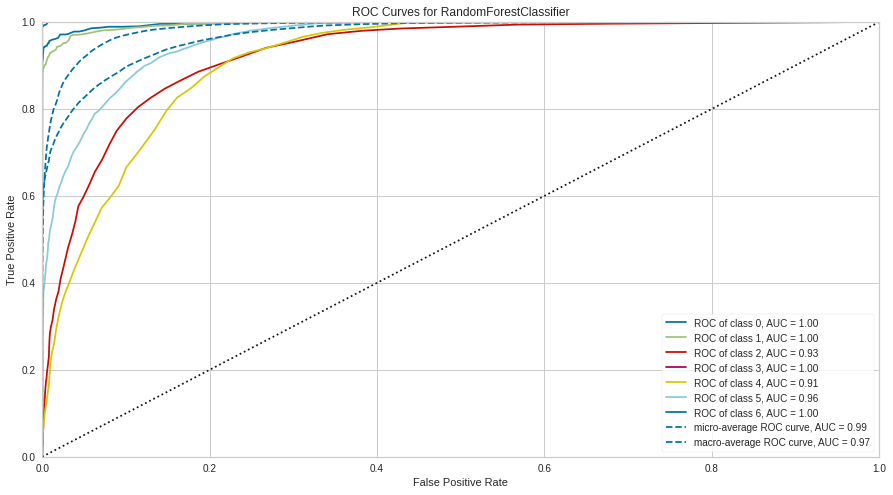

In [ ]:
from yellowbrick.classifier import ROCAUC

fig, ax = plt.subplots(figsize = (15,8))
visualizer = ROCAUC(rf, ax=ax)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)   
visualizer.show()

SVM

In [ ]:
%%time

from sklearn.svm import SVC  

svm = SVC().fit(X_train,y_train)

predictions= svm.predict(X_test)

train_acc = svm.score(X_train, y_train)*100
test_acc = svm.score(X_test, y_test)*100


CPU times: user 3h 2min 24s, sys: 5.44 s, total: 3h 2min 29s
Wall time: 3h 2min 10s


In [ ]:
print("Accuracy on training set: {:.3f}%. \n".format(train_acc))
print("Accuracy on test set: {:.3f}%. \n".format(test_acc))

print("Classification Report: \n",classification_report(y_test, predictions, target_names=target)) 
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predictions)
cm =pd.DataFrame(cm, index=target, columns=target)
cm

Accuracy on training set: 77.874%. 

Accuracy on test set: 75.124%. 

Classification Report: 
               precision    recall  f1-score   support

       akiec       0.64      0.61      0.62       900
         bcc       0.66      0.73      0.69      1350
         bkl       0.55      0.30      0.39       989
          df       0.82      0.67      0.74       900
         mel       0.61      0.15      0.24      1002
          nv       0.78      0.95      0.85      6035
        vasc       0.93      0.85      0.89       900

    accuracy                           0.75     12076
   macro avg       0.71      0.61      0.63     12076
weighted avg       0.74      0.75      0.72     12076


Confusion Matrix:


akiec  bcc  bkl   df  mel    nv  vasc
akiec    548  152   26   43    4   121     6
bcc       83  987   39   36   11   170    24
bkl       69   87  299   19   29   481     5
df        34  119    8  602    0   137     0
mel       42   22   82   12  153   687     4
nv        49   88   89   24   53  5714    18
vasc      35   39    3    2    0    52   769

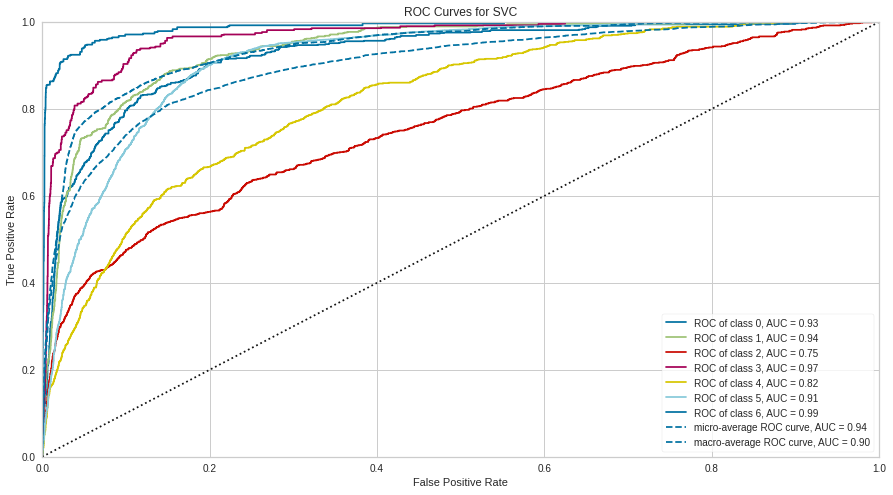

In [ ]:
from yellowbrick.classifier import ROCAUC

fig, ax = plt.subplots(figsize = (15,8))
visualizer = ROCAUC(svm, ax=ax)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)   
visualizer.show()